In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from safetensors import safe_open
import os

In [2]:
def load_study_and_extract_name(folder):
    # get data between facebook/ and UR50D_
    model_name = folder.split('facebook/')[1].split('UR50D_')[0] + 'UR50D'
    dataset_name = folder.split(model_name+"_")[1].split('_seed')[0]

    with safe_open(folder + f"/scores_facebook/{model_name}_{dataset_name}/pairwise_scores.safetensors", "pt") as f:
        for k in f.keys():
            return model_name, dataset_name, f.get_tensor(name=k).numpy(force=True).squeeze()

In [3]:
def get_hamming_distances(study_name, seed=0):
    all_dms_df = pd.read_csv("../DMS_substitutions.csv")
    seq = all_dms_df[all_dms_df["DMS_id"] == study_name]["target_seq"].iloc[0]
    seqs_df = pd.read_csv(f"../studies/{study_name}.csv")
    # sample 1000 sequences without replacement
    seqs_df = seqs_df.sample(n=1000, random_state=seed, replace=False)
    seqs = seqs_df["mutated_sequence"].tolist()
    return [sum([1 for i in range(len(seq)) if seq[i] != seqs[j][i]]) for j in range(len(seqs))]

In [4]:
prefix_dir = "../analyses/facebook/"
analyses = {}
hammings = {}
for p in os.listdir(prefix_dir):
    print(p)
    model_name, dataset_name, scores = load_study_and_extract_name(prefix_dir + p)
    if dataset_name not in analyses:
        analyses[dataset_name] = {}
    analyses[dataset_name][model_name] = scores

for dataset_name in analyses:
    hammings[dataset_name] = get_hamming_distances(dataset_name) 

esm2_t36_3B_UR50D_F7YBW8_MESOW_Aakre_2015_seed=0
esm2_t33_650M_UR50D_GCN4_YEAST_Staller_2018_seed=0
esm2_t33_650M_UR50D_PHOT_CHLRE_Chen_2023_seed=0
esm2_t6_8M_UR50D_GFP_AEQVI_Sarkisyan_2016_seed=0
esm2_t12_35M_UR50D_D7PM05_CLYGR_Somermeyer_2022_seed=0
esm2_t12_35M_UR50D_HIS7_YEAST_Pokusaeva_2019_seed=0
esm2_t33_650M_UR50D_Q8WTC7_9CNID_Somermeyer_2022_seed=0
esm2_t33_650M_UR50D_GFP_AEQVI_Sarkisyan_2016_seed=0
esm2_t33_650M_UR50D_HIS7_YEAST_Pokusaeva_2019_seed=0
esm2_t36_3B_UR50D_PHOT_CHLRE_Chen_2023_seed=0
esm2_t36_3B_UR50D_D7PM05_CLYGR_Somermeyer_2022_seed=0
esm2_t6_8M_UR50D_F7YBW8_MESOW_Aakre_2015_seed=0
esm2_t30_150M_UR50D_D7PM05_CLYGR_Somermeyer_2022_seed=0
esm2_t12_35M_UR50D_GCN4_YEAST_Staller_2018_seed=0
esm2_t30_150M_UR50D_GCN4_YEAST_Staller_2018_seed=0
esm2_t33_650M_UR50D_Q6WV13_9MAXI_Somermeyer_2022_seed=0
esm2_t30_150M_UR50D_PHOT_CHLRE_Chen_2023_seed=0
esm2_t36_3B_UR50D_CAPSD_AAV2S_Sinai_2021_seed=0
esm2_t36_3B_UR50D_F7YBW7_MESOW_Ding_2023_seed=0
esm2_t36_3B_UR50D_GFP_AEQVI_Sa

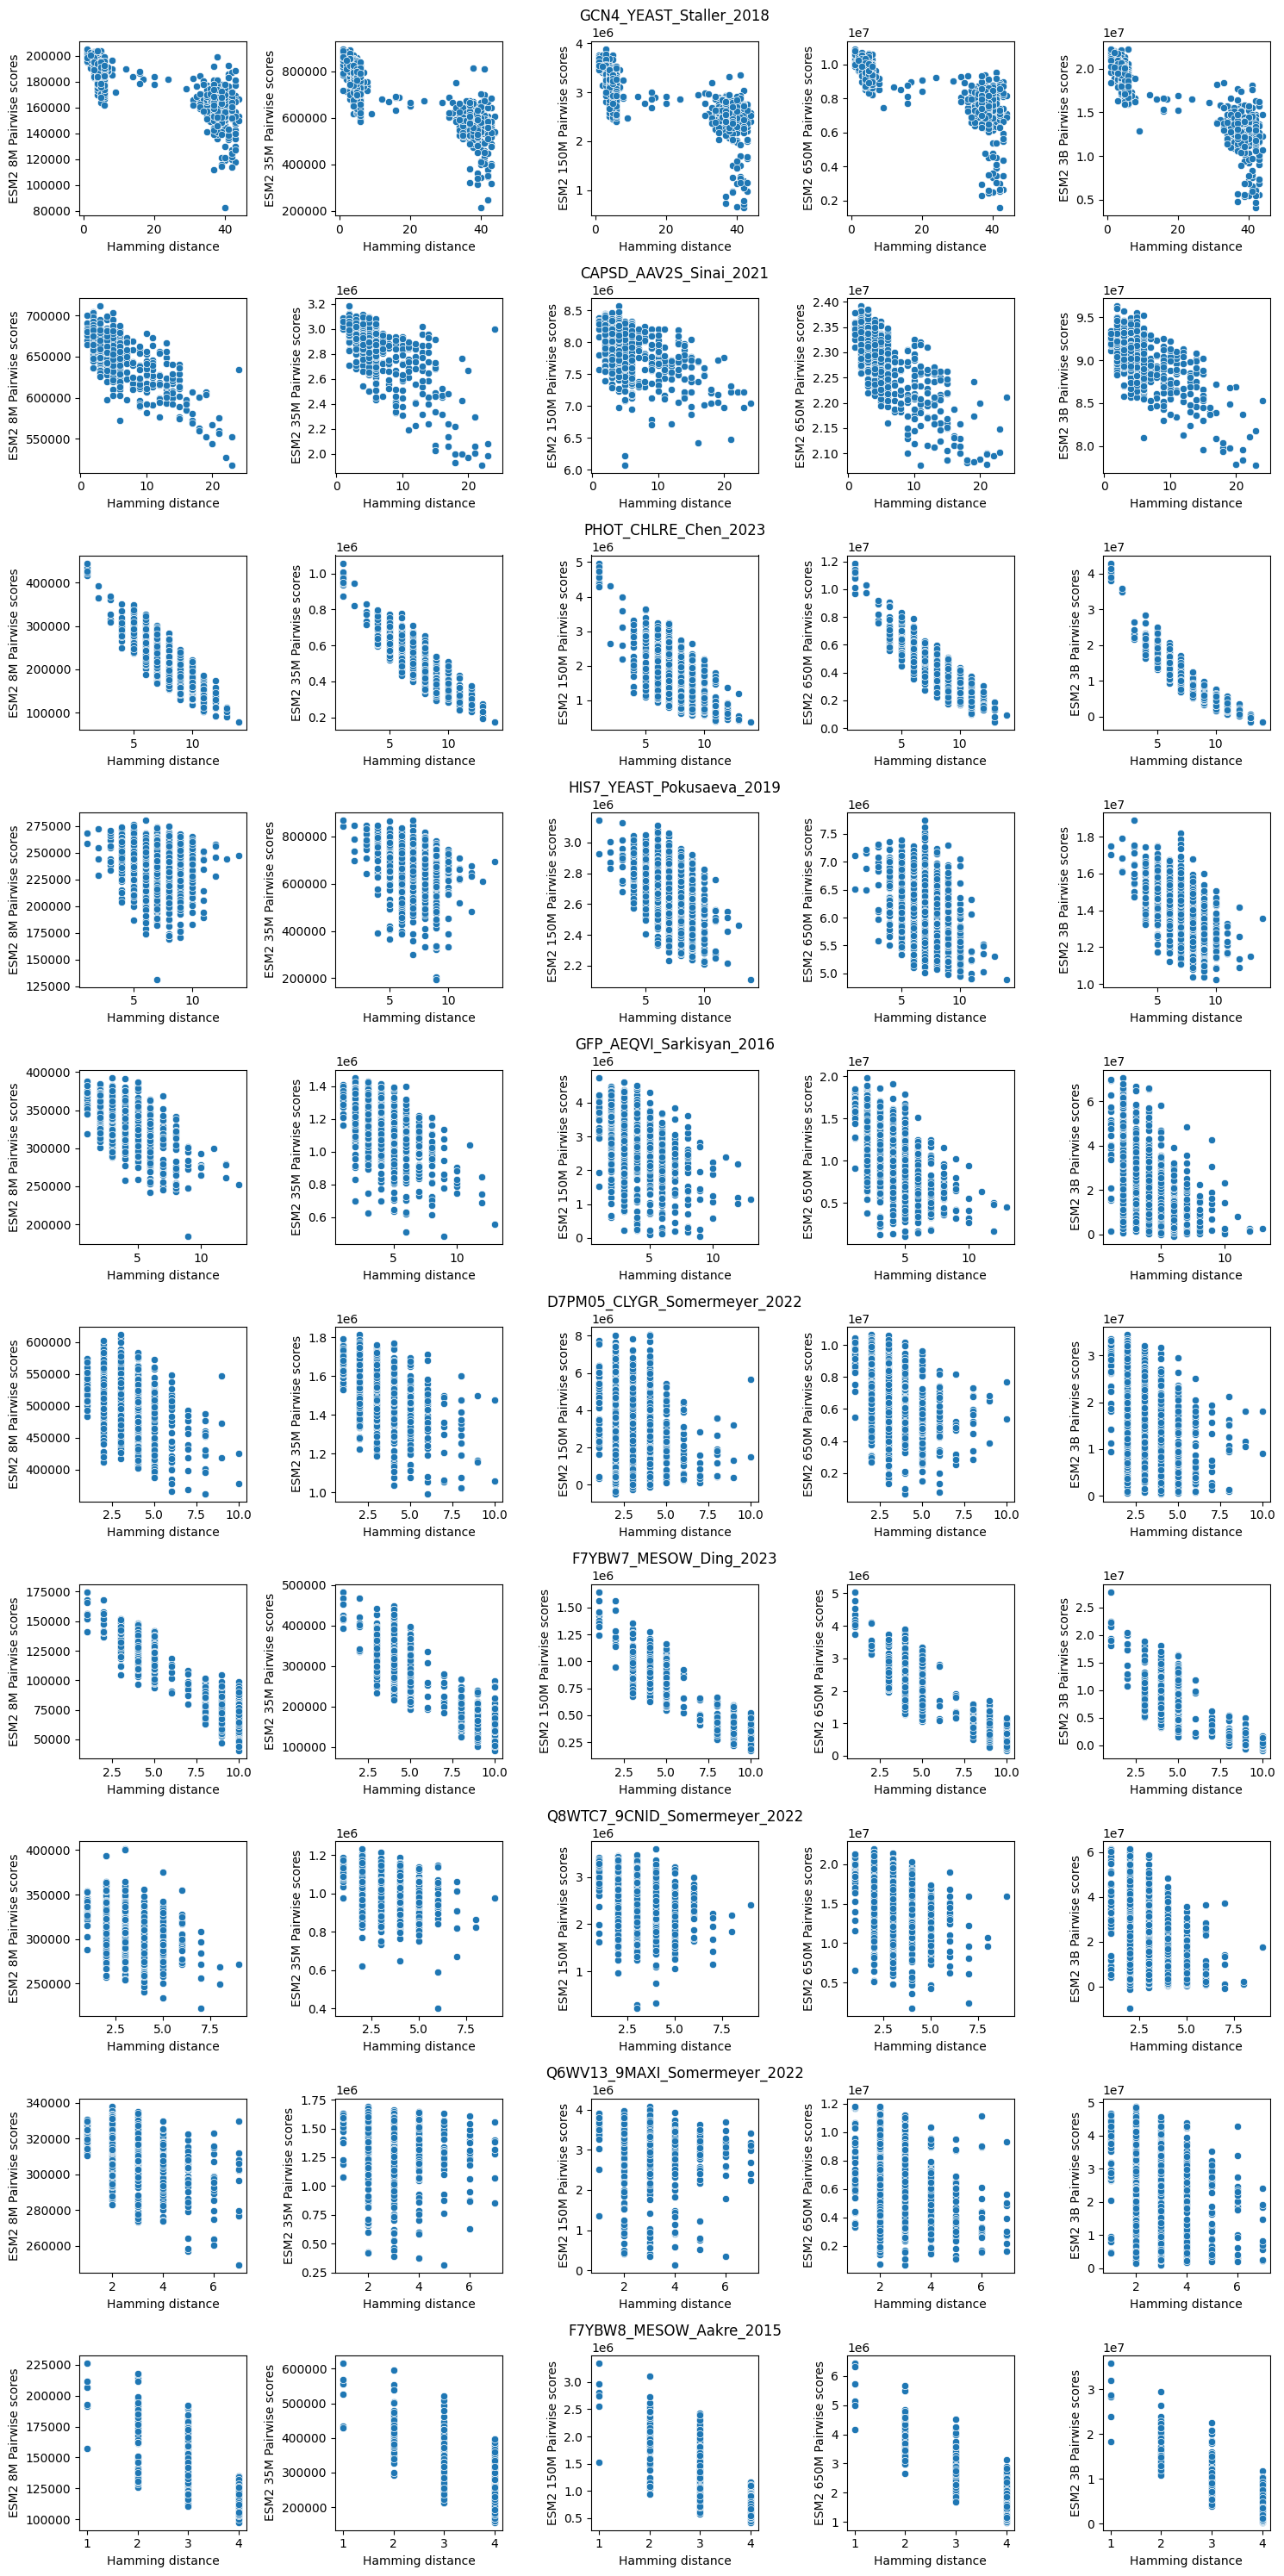

In [12]:
# make a len(analyses) x len(analyses[key]) plot of scatter plots
FIG_CONSTANT = 3
plt.figure(figsize=(FIG_CONSTANT*len(analyses['F7YBW8_MESOW_Aakre_2015']), FIG_CONSTANT*len(analyses)))

# sort analyses keys by max hamming distance
analyses_keys = sorted(analyses.keys(), key=lambda x: max(hammings[x]), reverse=True)
models = [
    "esm2_t6_8M_UR50D",
    "esm2_t12_35M_UR50D",
    "esm2_t30_150M_UR50D",
    "esm2_t33_650M_UR50D",
    "esm2_t36_3B_UR50D"
]

for i, dataset_name in enumerate(analyses_keys):
    for j, model_name in enumerate(models):
        plt.subplot(len(analyses), len(analyses[dataset_name]), i*len(analyses[dataset_name]) + j + 1)
        sns.scatterplot(x=hammings[dataset_name], y=analyses[dataset_name][model_name])
        plt.xlabel("Hamming distance")
        plt.ylabel(f"ESM2 {model_name.split('_')[2]} Pairwise scores")
        if j == 2:
            plt.title(f"{dataset_name}")

plt.tight_layout()

In [13]:
# for each model on each dataset calculate the spearman correlation between the hamming distance and the pairwise scores
spearmans = {}
for dataset_name in analyses:
    spearmans[dataset_name] = {}
    for model_name in models:
        spearmans[dataset_name][model_name] = pd.Series(hammings[dataset_name]).corr(pd.Series(analyses[dataset_name][model_name]), method='spearman')


In [14]:
# print the average spearman of each model accross all datasets
for model_name in models:
    print(f"Model {model_name} average spearman: {sum([spearmans[dataset_name][model_name] for dataset_name in spearmans])/len(spearmans)}")

Model esm2_t6_8M_UR50D average spearman: -0.5941479930257318
Model esm2_t12_35M_UR50D average spearman: -0.6155555948990326
Model esm2_t30_150M_UR50D average spearman: -0.5611431215791899
Model esm2_t33_650M_UR50D average spearman: -0.6174647102363494
Model esm2_t36_3B_UR50D average spearman: -0.6057734635275419
